<a href="https://colab.research.google.com/github/Pretzel-Solution/DNN-binaural-localization/blob/main/1_data_presentation_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
# install module to read SOFA files
# SOFA  (Spatially Oriented Format for Acoustics)
!pip install sofasonix

     |████████████████████████████████| 4.3MB 4.0MB/s 
     |████████████████████████████████| 296kB 14.8MB/s 
  Created wheel for sofasonix: filename=SOFASonix-1.0.6-cp36-none-any.whl size=35414 sha256=0bac3642bd2c45470f1074d39ff467f52785bc2706f275bb51519d2fd31e0aa9
  Stored in directory: /root/.cache/pip/wheels/3f/30/53/7460ffb640393d6299159d0c2f5cdecc8775dd8a91dfd18ea7
Successfully built sofasonix


# Import libraries and dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from SOFASonix import SOFAFile # read SOFA (Spatially Oriented Format for Acoustics)
from scipy import signal # STFT functionality
import scipy
import scipy.io.wavfile as wav # read wav file

## extract data
loadsofa = SOFAFile.load("/content/drive/My Drive/binaural_localization/HRIR_FULL2DEG.sofa")
data = loadsofa.data_ir
direction = loadsofa.SourcePosition
direction = direction[:,0:2] # discard the third column, because it is always the distance 3m
sr = int(loadsofa.Data_SamplingRate[0]) # sampling rate in Hz
# loadsofa.view() # display available SOFA data

Setting dimension 'r' from parameter 'ReceiverPosition'
Setting dimension 'e' from parameter 'EmitterPosition'
Setting dimension 'm' from parameter 'Data.IR'
Setting dimension 'n' from parameter 'Data.IR'
Inserting foreign parameter: 'GLOBAL:Author'
Inserting foreign parameter: 'GLOBAL:ListenerDescription'
Inserting foreign parameter: 'GLOBAL:ReceiverDescription'
Inserting foreign parameter: 'GLOBAL:SourceDescription'
Inserting foreign parameter: 'GLOBAL:RoomDescription'


# Explore dataset of head related impulse responses (HRIRs)

In [3]:
def get_i_d(az_wish, el_wish):
  '''
    Find the row index of the direction pair which is the closest do the desirec direction (az_wish, el_wish).
  '''
  m_altered = np.abs(direction[:,0]- az_wish) + np.abs(direction[:,1]- el_wish)
  m_min = np.amin(m_altered, axis=0)
  i_row = np.argwhere(m_altered == m_min)[0][0]
  return i_row

def plot_hrir(az_wish, el_wish):
  '''
    Plot the HRIR for the left and right ear for the direction (az_wish, el_wish)
  '''
  i_d = get_i_d(az_wish, el_wish)
  hrir_l, hrir_r = data[i_d][0], data[i_d][1]
  t = np.arange(len(data[i_d][0]))/sr*1000 # in ms

  fig, ax = plt.subplots(2,1, figsize=(8,5), constrained_layout=True)
  fig.patch.set_facecolor('white')
  fig.suptitle(f'Direction: ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation)', fontsize=16)  
  ax[0].plot(t, hrir_l)
  ax[0].set(title = 'HRIR left', xlabel='Time in ms', ylabel='Amplitude')
  ax[0].axis('tight')
  ax[1].plot(t, hrir_r)
  ax[1].set(title = 'HRIR right', xlabel='Time in ms', ylabel='Amplitude')
  ax[1].axis('tight')
  fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/HRIR Direction: ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation).png')


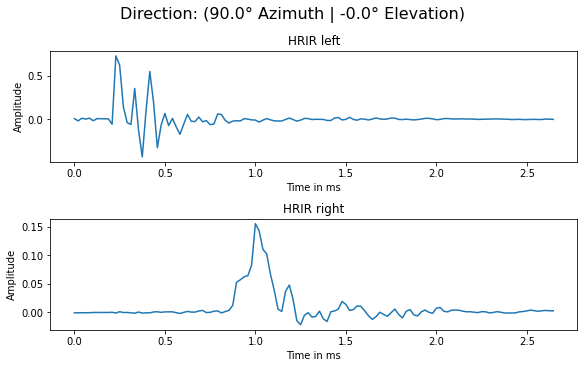

In [4]:
plot_hrir(az_wish=90, el_wish=0)

Reasonability calculation for (az_wish=90, el_wish=0):
- speed of sound: 343m/s
- distance from ear to ear: 0.15m
- propagation time: 0.15m / 343m/s = 0.4ms

time window = 25ms >> propagation time


# Directional sound simulation

In [5]:
## create noise signal
# white noise; independent random variables with uniform probability distribution
duration = 0.55 # in seconds
sample_n = int(duration*sr) # how many samples for a given duration; the same sampling rate is the same as for the HRIR signal
noise = np.random.uniform(-1,1,sample_n)

## create speech signal
# in the same way one can analyse any other signal sampled with 48kHz and encoded in a wav file
# Audacity is a freely available program to record such wav files
load_speech = wav.read('/content/drive/My Drive/binaural_localization/hallo_speech.wav')
speech = load_speech[1]
sampling_rate = load_speech[0]
if sampling_rate != sr:
  print('Warning: sampling_rate != sr')

def plot_directional_sound(signal, az_wish, el_wish, signal_name=None):
  '''
    Plot the time response for the left and right ear for the signal coming from the direction (az_wish, el_wish)
    INPUT:
      signal:           1D numpy array being the speech or noise signal
      az_wish, el_wigh: Azimuth and elevation for which the sound should come frome
      signal_name:      string; the name of the kind of signal which sould be used to save the picture
                        if None the figure is only displayed inline and not saved
  '''
  i_d = get_i_d(az_wish, el_wish)
  # select HRIRs for the desired direction
  hrir_l, hrir_r = data[i_d][0], data[i_d][1]
  # simulate the what reaches the left ear by convolving the mono signal with the HRIR of the left ear of the requested direction
  left = np.convolve(signal, hrir_l, mode='valid') 
  # 'valid': avoid boundary effects; The convolution product is only given for points where the signals overlap completely
  right = np.convolve(signal, hrir_r, mode='valid')
  t = np.arange(len(left))/sr*1000 # in ms
  
  fig, ax = plt.subplots(2,1, figsize=(8,5), constrained_layout=True)
  fig.patch.set_facecolor('white')
  fig.suptitle(f'Direction: ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation)', fontsize=16)  
  ax[0].plot(t, left)
  ax[0].set(title = 'Sound left', xlabel='Time in ms', ylabel='Amplitude')
  ax[1].plot(t, right)
  ax[1].set(title = 'Sound right', xlabel='Time in ms', ylabel='Amplitude')
  if signal_name != None:
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/time {signal_name} ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation).png')

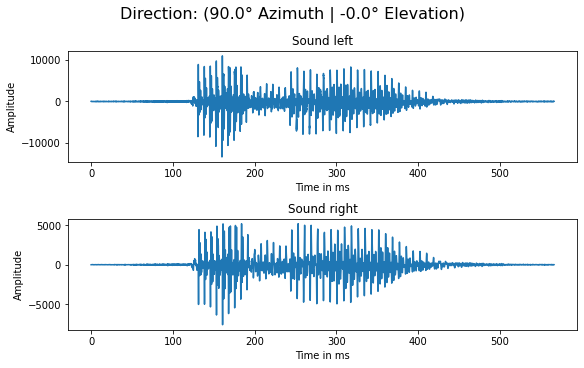

In [6]:
plot_directional_sound(signal=speech, az_wish=90, el_wish=0, signal_name='speech')

# Data preprocessing

## Short time Fourier transformation (STFT)

In [7]:
def get_spec(time_signal):
  '''
    Calculate the short time Fourier transformation (STFT)
    INPUT:
      time_signal:  1D numpy array being the accoustic signal in time domain
    OUTPUT:
      complex_spec: 2D numpy array of dimension (len(f) x len(t)); STFT spectrogram 
      f:            1D array of frequency bins
      t:            1D array of time frame bins
  '''
  win_length = int(sr*0.025) # 0.025s
  hop_length = 0.01 # in s
  nfft= win_length + 0 # 0 zero padding for time frames
  f, t, complex_spec = scipy.signal.spectrogram(time_signal, 
                               fs= sr,
                               window='hann', #'hann': cosine window; ('tukey', 0.25) creates a constant plateau in between
                               nperseg= win_length, 
                               noverlap= int(sr*(0.025-hop_length)), # overlap = 25ms win_length - 10ms hop_length = 15ms
                               nfft= nfft,
                               detrend= False, #if 'constant': for every time frame substract its mean;
                               return_onesided= True, # return a one-sided spectrum for real data
                               scaling= 'density', # units of V**2/Hz, but should have no influence, since mode = ‘complex’
                               axis= -1, 
                               mode= 'complex')
  return f, t, complex_spec

def plot_spec(signal, az_wish, el_wish, signal_name=None):
  '''
    Plot amplitude and phase spectrograms for the left and right ear for a signal coming from direction (az_wish, el_wish)
    INPUT:
      signal:           1D numpy array being the accoustic signal in time domain
      az_wish, el_wigh: Azimuth and elevation being the direction of arrival (DOA) from which the sound is simulated 
      signal_name:      string; the name of the kind of signal which sould be used to save the picture
                        if None the figure is only displayed inline and not saved
  '''
  i_d = get_i_d(az_wish, el_wish)
  hrir_l, hrir_r = data[i_d][0], data[i_d][1]
  f_l, t_l, complex_spec_l = get_spec(np.convolve(signal, hrir_l, mode='valid'))
  f_r, t_r, complex_spec_r = get_spec(np.convolve(signal, hrir_r, mode='valid'))
  t_l, t_r = t_l*1000, t_r*1000 # in ms
  f_l, f_r = f_l/1000, f_r/1000 # in kHz
  f_mask = np.logical_and(f_l >= 0.020, f_l <= 20) # select frequencies form 20Hz to 20kHz

  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
  fig.suptitle(f'Direction: ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation)', fontsize=16)  
  fig.patch.set_facecolor('white')

  im = ax[0,0].pcolormesh(t_l, f_l[f_mask], 20*np.log10(np.abs(complex_spec_l))[f_mask] )
  cb = plt.colorbar(im, ax=ax[0,0])
  cb.set_label('dB')
  ax[0,0].set(title = 'Amplitude spectrogram left', xlabel='Time in ms', ylabel='Frequency in kHz')
  fig.tight_layout()

  im = ax[1,0].pcolormesh(t_l, f_l[f_mask], np.angle(complex_spec_l)[f_mask] )
  cb = plt.colorbar(im, ax=ax[1,0])
  cb.set_label('rad')
  ax[1,0].set(title = 'Phase spectrogram left', xlabel='Time in ms', ylabel='Frequency in kHz')
  fig.tight_layout()

  im = ax[0,1].pcolormesh(t_l, f_l[f_mask], 20*np.log10(np.abs(complex_spec_r))[f_mask] )
  cb = plt.colorbar(im, ax=ax[0,1])
  cb.set_label('dB')
  ax[0,1].set(title = 'Amplitude spectrogram right', xlabel='Time in ms', ylabel='Frequency in kHz')
  fig.tight_layout()

  im = ax[1,1].pcolormesh(t_l, f_l[f_mask], np.angle(complex_spec_r)[f_mask] )
  cb = plt.colorbar(im, ax=ax[1,1])
  cb.set_label('rad')
  ax[1,1].set(title = 'Phase spectrogram right', xlabel='Time in ms', ylabel='Frequency in kHz')
  fig.tight_layout()

  fig.subplots_adjust(top=0.85)
  if signal_name != None:
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/spec {signal_name} ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation).png')

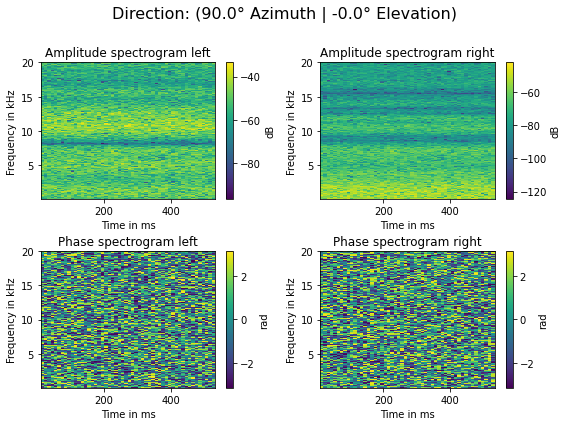

In [8]:
plot_spec(signal=noise, az_wish=90, el_wish=0, signal_name='noise')

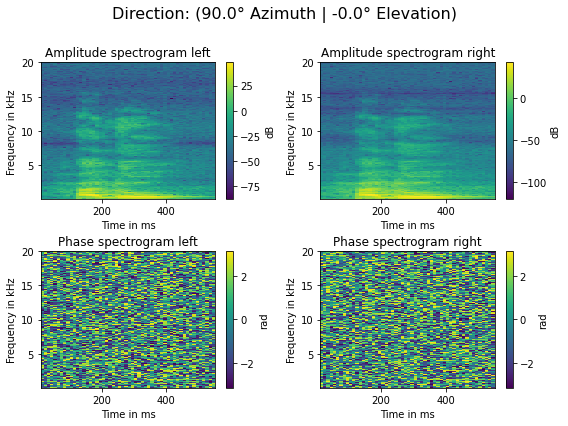

In [9]:
plot_spec(signal=speech, az_wish=90, el_wish=0, signal_name='speech')

STFT shows bands of attenuation in the amplitude spectrogram. Those bands are direction dependent. Still, the spectrogram is different for different kinds of sound sources. We are searching for an input which is only dependent on the direction of arrival. (Only thaving the characteristic bands.)

## Interaural level difference (ILD) and interaural phase difference (IPD)

In [10]:
def plot_spec_diff(signal, az_wish, el_wish, signal_name=None):
  '''
    Plot amplitude and phase spectrograms differences between the left and right ear for a signal coming from direction (az_wish, el_wish)
    INPUT:
      signal:           1D numpy array being the accoustic signal in time domain
      az_wish, el_wigh: Azimuth and elevation being the direction of arrival (DOA) from which the sound is simulated 
      signal_name:      string; the name of the kind of signal which sould be used to save the picture
                        if None the figure is only displayed inline and not saved
  '''
  i_d = get_i_d(az_wish, el_wish)
  hrir_l, hrir_r = data[i_d][0], data[i_d][1]
  f_l, t_l, complex_spec_l = get_spec(np.convolve(signal, hrir_l, mode='valid'))
  f_r, t_r, complex_spec_r = get_spec(np.convolve(signal, hrir_r, mode='valid'))
  t_l, t_r = t_l*1000, t_r*1000 # in ms
  f_l, f_r = f_l/1000, f_r/1000 # in kHz
  f_mask = np.logical_and(f_l >= 0.02, f_l <= 20) # select frequencies form 20Hz to 20kHz

  fig, (ax00, ax10)= plt.subplots(nrows=2, ncols=1, figsize=(8,5))
  fig.suptitle(f'Direction: ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation)', fontsize=16)  
  fig.patch.set_facecolor('white')

  # log(hrtf_l) - log(hrtf_r) is numerically more stable than hrtf_l/hrtf_r
  ILD = 20*np.log10(np.abs(complex_spec_l))-20*np.log10(np.abs(complex_spec_r))
  spec00 = ax00.pcolormesh(t_l, f_l[f_mask], ILD[f_mask] )
  cb = plt.colorbar(spec00, ax=ax00)
  cb.set_label('dB')
  ax00.set(title = 'Interaural level difference (ILD)', xlabel='Time in ms', ylabel='Frequency in kHz')
  fig.tight_layout()

  IPD = np.angle(complex_spec_l)-np.angle(complex_spec_r)
  spec10 = ax10.pcolormesh(t_l, f_l[f_mask], IPD[f_mask] )
  cb = plt.colorbar(spec10, ax=ax10)
  cb.set_label('rad')
  ax10.set(title = 'Interaural phase difference (IPD)', xlabel='Time in ms', ylabel='Frequency in kHz')
  fig.tight_layout()

  fig.subplots_adjust(top=0.85) 
  if signal_name != None:
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/spec diff {signal_name} ({direction[i_d][0]}° Azimuth | {round(direction[i_d][1],1)}° Elevation).png')

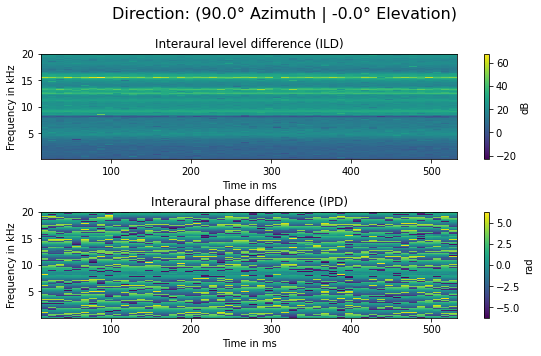

In [11]:
plot_spec_diff(signal=noise, az_wish=90, el_wish=0, signal_name='noise')

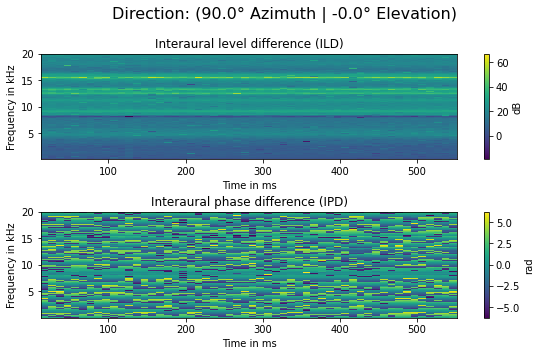

In [12]:
plot_spec_diff(signal=speech, az_wish=90, el_wish=0, signal_name='speech')

ILDs look the same for noise and speech. Hence, it shows the independancy of the kind of sound source. IPDs are still very noisy.

---
How do ILDs change over directions? Is there a distinct relation?

In [13]:
def plot_ILD_over_az(signal, el, signal_name=None):
  '''
    Plot interaural level differences (ILDs) over n_az azimuth angles in the range from 0 degree to 360 degree as a heatmap for a given elevation el
    INPUT:
      signal:           1D numpy array being the accoustic signal in time domain
      el:               elevation at which ILDs are are plotted over azimuth
      signal_name:      string; the name of the kind of signal which sould be used to save the picture
                        if None the figure is only displayed inline and not saved
  '''
  n_az = 400 # set emperically; there are direction repetitions, but not too many
  az = np.zeros(n_az)
  for i, az_i in enumerate(np.linspace(0,360, n_az)):
    i_d = get_i_d(az_wish = az_i, el_wish=0)
    hrir_l, hrir_r = data[i_d][0], data[i_d][1]
    f_l, t_l, complex_spec_l = get_spec(np.convolve(signal, hrir_l, mode='valid'))
    f_r, t_r, complex_spec_r = get_spec(np.convolve(signal, hrir_r, mode='valid'))
    ILD = 20*np.log10(np.abs(complex_spec_l)) - 20*np.log10(np.abs(complex_spec_r))
    if i == 0:
      f = f_l
      m = np.zeros((len(f_l),n_az))
    m[:,i] = np.mean(ILD, axis=1)
    az[i] = direction[i_d, 0]
  
  f_mask = np.logical_and(f >= 20, f <= 20000) # select frequencies form 20Hz to 20kHz

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
  fig.patch.set_facecolor('white')
  spec = ax.pcolormesh(az, f[f_mask]/1000, m[f_mask])
  cb = plt.colorbar(spec, ax=ax)
  cb.set_label('dB')
  ax.set(title = f'Interaural level difference over azimuth with {el}° elevation', xlabel='Azimuth in degree', ylabel='Frequency in kHz')
  fig.tight_layout()
  fig.subplots_adjust(top=0.85)
  if signal_name != None:
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/ILD {signal_name} over Azimuth with Elevation {el}°.png')

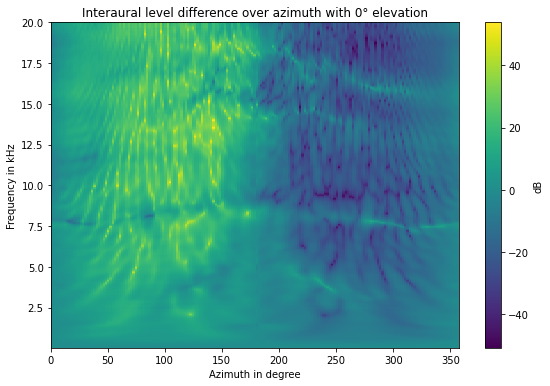

In [14]:
plot_ILD_over_az(signal=noise, el=0, signal_name='noise')

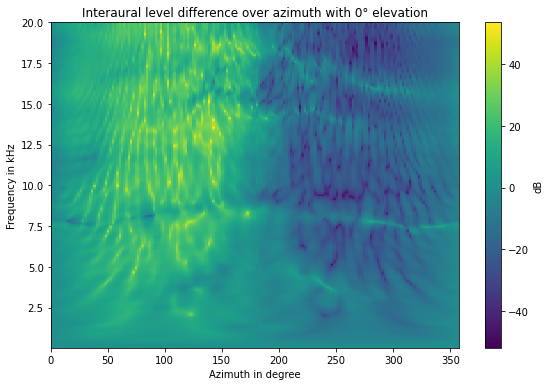

In [15]:
plot_ILD_over_az(signal=speech, el=0, signal_name='speech')

ILDs show a characteristic direction dependent pattern which again is independent of the kind of sound source

In [16]:
def plot_ILD_over_el(signal, az, signal_name=None):
  '''
    Plot interaural level differences (ILDs) over n_el elevation angles in the range from -90 degree to 90 degree as a heatmap for a given azimuth az
    INPUT:
      signal:           1D numpy array being the accoustic signal in time domain
      az:               azimuth at which ILDs are are plotted over elevation
      signal_name:      string; the name of the kind of signal which sould be used to save the picture
                        if None the figure is only displayed inline and not saved
  '''
  n_el = 1000 # set emperically; there are repetitions, but not too many
  el = np.zeros(n_el)
  for i, el_i in enumerate(np.linspace(-90, 90, n_el)):
    i_d = get_i_d(az_wish = az, el_wish=el_i)
    hrir_l, hrir_r = data[i_d][0], data[i_d][1]
    f_l, t_l, complex_spec_l = get_spec(np.convolve(signal, hrir_l, mode='valid'))
    f_r, t_r, complex_spec_r = get_spec(np.convolve(signal, hrir_r, mode='valid'))
    ILD = 20*np.log10(np.abs(complex_spec_l)) - 20*np.log10(np.abs(complex_spec_r))
    if i == 0:
      f = f_l
      m = np.zeros((len(f_l),n_el))
    m[:,i] = np.mean(ILD, axis=1)
    el[i] = direction[i_d, 1]

  f_mask = np.logical_and(f >= 20, f <= 20000) # select frequencies form 20Hz to 20kHz

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
  fig.patch.set_facecolor('white')
  spec = ax.pcolormesh(el, f[f_mask]/1000, m[f_mask] )
  cb = plt.colorbar(spec, ax=ax)
  cb.set_label('dB')
  ax.set(title = f'Interaural level difference over elevation with {az}° azimuth', xlabel='Elevation in degree', ylabel='Frequency in kHz')
  fig.tight_layout()
  fig.subplots_adjust(top=0.85)
  if signal_name != None:
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/ILD {signal_name} over Elevation with Azimuth {az}°.png')

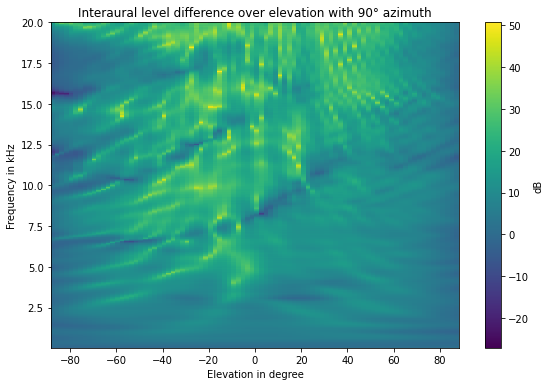

In [17]:
plot_ILD_over_el(signal=noise, az=90, signal_name='noise')

Tn contrast to the ILD pattern over azimuth, the ILD pattern over elevation is asymmetric because the head is asymmetric in elevation direction

In [18]:
def plot_IPD_over_az(signal, el, signal_name=None):
  '''
    Plot interaural phase differences (IPDs) over n_az azimuth angles in the range from 0 degree to 360 degree as a heatmap for a given elevation el
    INPUT:
      signal:           1D numpy array being the accoustic signal in time domain
      el:               elevation at which ILDs are are plotted over azimuth
      signal_name:      string; the name of the kind of signal which sould be used to save the picture
                        if None the figure is only displayed inline and not saved
  '''
  n_az = 400 # set emperically; there are repetitions, but not too many
  az = np.zeros(n_az)
  for i, az_i in enumerate(np.linspace(0,360, n_az)):
    i_d = get_i_d(az_wish = az_i, el_wish=0)
    hrir_l, hrir_r = data[i_d][0], data[i_d][1]
    f_l, t_l, complex_spec_l = get_spec(np.convolve(signal, hrir_l, mode='valid'))
    f_r, t_r, complex_spec_r = get_spec(np.convolve(signal, hrir_r, mode='valid'))
    IPD = np.angle(complex_spec_l) - np.angle(complex_spec_r)
    if i == 0:
      f = f_l
      m = np.zeros((len(f_l),n_az))
    m[:,i] = np.mean(IPD, axis=1)
    az[i] = direction[i_d, 0]

  f_mask = np.logical_and(f >= 20, f <= 20000) # select frequencies form 20Hz to 20kHz

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
  fig.patch.set_facecolor('white')
  spec = ax.pcolormesh(az, f[f_mask]/1000, m[f_mask] )
  cb = plt.colorbar(spec, ax=ax)
  cb.set_label('rad')
  ax.set(title = f'Interaural phase difference (IPD) over azimuth with {el}° elevation', xlabel='Azimuth in degree', ylabel='Frequency in kHz')
  fig.tight_layout()
  fig.subplots_adjust(top=0.85)
  if signal_name != None:
    fig.savefig(f'/content/drive/My Drive/binaural_localization/pictures/IPD {signal_name} over Azimuth with Elevation {el}°.png')

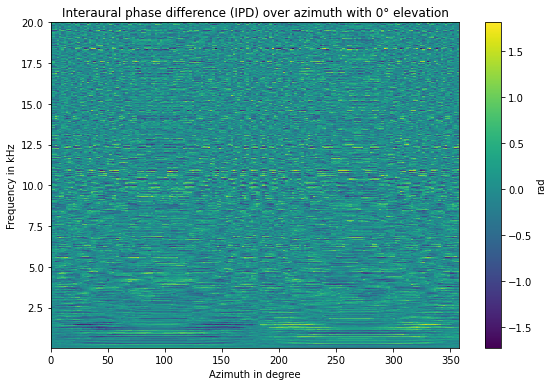

In [19]:
plot_IPD_over_az(signal=speech, el=0, signal_name='speech')

IPDs are unsuitable as input because they lack distinct patterns which can be learned by the DNN. Further preprocessing to derive interaural time difference (ITD) would solve the problem but is beyond the scope of this project.